# PORTAFOLIOS TIPO MARKOWIT

En este notebook se generarán portofolios con acciones pertenecientes al S&P 500 con el fin de evaluar su desempeño por fuera de los datos de optimización.  Se utilizarán ventanas de optimización de 2 años y de pruebas de 6 meses

### Carga de Librerias

In [143]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize
import scipy
import os
import pickle

import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Declaración de Funciones

In [44]:
def annualize_rets(r, periods_per_year):
    "anualiza retorns desde subperiodos de año"
    compounded_growth = np.prod(1+r)
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year / n_periods)-1

In [45]:
def carga_datos(path):
    df = pd.read_parquet(path)
    df.set_index('Date', inplace=True)
    return df

In [46]:
def portfolio_vol(weights, covmat):
    """
    weights -> volatility
    """
    return (weights.T @ covmat @ weights)**0.5

In [47]:
def portfolio_return(weights, returns):
    """
    weights -> Returns
    """
    return weights.T @ returns  #matrix or vector multiplicacion 

In [48]:
def msr(riskfree_rate, er, cov):
    """
    f(riskfree_rate, ER, cov) -> w
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        negative sharpe_ratio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    
    weights = scipy.optimize.minimize(fun = neg_sharpe_ratio, x0 = init_guess, args = (riskfree_rate, er, cov,),
                       method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return weights.x

In [49]:
def portafolio_markowitz(datos, dias_trading, rf):
    cov = datos.cov()
    anual_returns = annualize_rets(datos1, dias_trading)
    pesos = msr(rf, anual_returns, cov)
    return pesos

### Carga de Datos para 1 periodo

Los datos contienen rendimientos para 465 acciones, la primera ventana de datos contiene 504 rendimientos diarios desde 01 de enero de 2013 hasta el 31 de diciembre de 2014.  Dos años.

In [50]:
datos1 = carga_datos('./Data/train/opt-20130101-20141231.gzip')

In [51]:
datos1.shape

(504, 465)

In [81]:
tickers1=datos1.columns
tickers1

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'XEL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA',
       'ZION'],
      dtype='object', name='Stock', length=465)

In [52]:
datos1.head()

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.022960,0.035556,0.001935,0.031681,0.007179,0.018601,0.019827,0.038496,0.017516,0.046125,...,0.025084,0.034300,0.024957,0.022974,0.054252,0.014760,0.011446,0.015602,0.041974,0.027570
2013-01-03,0.003582,-0.022890,0.000000,-0.012622,-0.002070,-0.017531,0.038065,-0.003620,-0.015389,-0.016137,...,-0.002922,-0.001887,-0.001803,-0.002715,0.000000,-0.003273,0.006254,0.014328,0.000977,0.001364
2013-01-04,0.019748,0.078331,0.015589,-0.027855,0.006682,-0.002974,-0.006011,0.005522,0.010066,-0.017787,...,0.003663,-0.014047,0.004630,0.008661,-0.011126,-0.001459,0.010950,0.005097,-0.008049,0.028611
2013-01-07,-0.007233,0.007468,-0.003396,-0.005882,0.003205,-0.011931,0.008164,-0.004336,-0.004983,0.003057,...,-0.010584,-0.004110,-0.011578,0.003435,0.016877,-0.013153,-0.006294,0.002463,0.005655,-0.004857
2013-01-08,-0.007991,0.021563,-0.016356,0.002691,-0.001369,-0.003019,0.000300,0.005806,0.005272,-0.010317,...,0.001844,-0.020358,0.006255,-0.011492,-0.001383,-0.012218,-0.041980,0.001445,0.000733,-0.019964


In [53]:
datos1.tail(2)

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-30,0.000968,0.010785,-0.007381,-0.012203,-0.00382,-0.003118,0.001974,-0.003646,-0.014164,-0.009272,...,-0.023356,-0.005481,-0.000537,-0.007258,-0.009194,-0.011065,-0.003806,0.009427,0.003459,-0.001741
2014-12-31,-0.010394,0.003931,-0.004687,-0.019019,-0.01227,-0.007821,-0.014664,-0.009757,-0.005200,-0.000720,...,-0.012645,-0.005970,-0.006128,-0.001312,-0.010706,-0.009368,-0.005868,-0.010038,-0.011619,-0.005581


### Calculo del Portafolio para 1 periodo

In [54]:
cov1 = datos1.cov()

In [55]:
cov1

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Stock,,,,,,,,,,,,,,,,,,,,,
A,0.000194,0.000095,0.000064,0.000033,0.000045,0.000058,0.000062,0.000067,0.000072,0.000082,...,0.000025,0.000081,0.000048,0.000065,0.000087,0.000090,0.000069,0.000068,0.000080,0.000084
AAL,0.000095,0.000555,0.000073,0.000037,0.000061,0.000104,0.000049,0.000069,0.000106,0.000081,...,0.000027,0.000069,0.000030,0.000071,0.000080,0.000099,0.000083,0.000066,0.000100,0.000085
AAP,0.000064,0.000073,0.000241,0.000026,0.000038,0.000063,0.000059,0.000044,0.000067,0.000050,...,0.000030,0.000055,0.000030,0.000042,0.000063,0.000053,0.000052,0.000045,0.000048,0.000055
AAPL,0.000033,0.000037,0.000026,0.000255,0.000010,0.000029,0.000018,0.000025,0.000029,0.000048,...,0.000010,0.000020,0.000017,0.000024,0.000041,0.000036,0.000031,0.000052,0.000038,0.000035
ABC,0.000045,0.000061,0.000038,0.000010,0.000095,0.000065,0.000044,0.000037,0.000048,0.000040,...,0.000024,0.000033,0.000029,0.000042,0.000044,0.000042,0.000036,0.000040,0.000033,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.000090,0.000099,0.000053,0.000036,0.000042,0.000078,0.000046,0.000059,0.000092,0.000082,...,0.000022,0.000087,0.000058,0.000063,0.000089,0.000251,0.000081,0.000060,0.000064,0.000081
YUM,0.000069,0.000083,0.000052,0.000031,0.000036,0.000061,0.000041,0.000045,0.000068,0.000056,...,0.000028,0.000051,0.000044,0.000049,0.000057,0.000081,0.000184,0.000049,0.000043,0.000064
ZBH,0.000068,0.000066,0.000045,0.000052,0.000040,0.000068,0.000061,0.000048,0.000054,0.000056,...,0.000031,0.000032,0.000041,0.000056,0.000076,0.000060,0.000049,0.000144,0.000060,0.000055


In [60]:
anual_returns = annualize_rets(datos1, 253)
anual_returns

Stock
A       0.193463
AAL     1.003660
AAP     0.489474
AAPL    0.233786
ABC     0.468110
          ...   
XYL     0.204535
YUM     0.069134
ZBH     0.319408
ZBRA    0.405177
ZION    0.160795
Length: 465, dtype: float64

Asumiendo una tasa libre de riesgo del 2%, se obtienen los pesos con el método de media varianza de Markowitzs

In [58]:
pesos1 = msr(0.02, anual_returns, cov1)

In [59]:
pesos1[0:10]

array([0.00000000e+00, 3.50119845e-10, 7.68373040e-10, 9.37324437e-10,
       5.81783430e-02, 9.06382370e-10, 3.06900863e-10, 0.00000000e+00,
       6.06100990e-11, 0.00000000e+00])

In [61]:
pesos1.shape

(465,)

Existe otra función que integra todo los anteriores calculos para los pesos optimos de markowitz.  Equivale al portafolio que maximiza el sharpe ratio.  El parametro de dias de trading se refiere al numero de dias habiles de tradin en un año

In [62]:
pesos2 = portafolio_markowitz(datos1, dias_trading=253, rf=0.02)

In [63]:
pesos2

array([0.00000000e+00, 3.50119845e-10, 7.68373040e-10, 9.37324437e-10,
       5.81783430e-02, 9.06382370e-10, 3.06900863e-10, 0.00000000e+00,
       6.06100990e-11, 0.00000000e+00, 9.61104147e-10, 5.23200163e-10,
       0.00000000e+00, 1.44311720e-09, 1.32632302e-09, 6.10831805e-11,
       0.00000000e+00, 0.00000000e+00, 9.93236172e-10, 6.50306708e-10,
       1.29925251e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.44368651e-10, 0.00000000e+00, 2.69087153e-10,
       8.91540624e-02, 0.00000000e+00, 0.00000000e+00, 2.15322769e-10,
       0.00000000e+00, 3.82992374e-10, 0.00000000e+00, 0.00000000e+00,
       9.82750336e-10, 3.56663819e-10, 0.00000000e+00, 0.00000000e+00,
       4.40979606e-10, 0.00000000e+00, 0.00000000e+00, 8.65200968e-10,
       1.20526634e-09, 1.37900834e-10, 8.52805116e-10, 9.25942215e-10,
       0.00000000e+00, 1.30594091e-09, 0.00000000e+00, 8.25861613e-10,
       3.91862237e-10, 0.00000000e+00, 8.78550393e-12, 1.78501754e-03,
      

In [67]:
pesos_cero = (pesos2 == 0).sum()
pesos_cero

205

En la respuesta obtenida se puede observar que del total de 465 acciones, el método de markowitzs incluye 260 acciones en el portafolio óptimo y excluye de la solución a 205 acciones.    Este porfafolio tinene los siguientes problemas

* Demasiados activos en el portafolio. Diversos estudios han mostrado que la diversificación marginal tiende a cero en el tiempo y que con 30 acciones ya se cuenta con suficiente diversificación.
* El costo de rebalanceo de este portafolio es alto pues contiene muchos activos
* De las 260 acciones incluidas en el portafolio hay algunas con una participación muy cercana cero

### Carga de datos para todos los periodos

In [68]:
#cargar nombres y rutas de los archivos de entrenamiento
archivos = []
path_train = "./Data/train/"
for root, dirs, files in os.walk("./Data/train/"):
    for filename in files:
        temp = path_train + filename
        archivos.append(temp)

Hay un total de 24 periodos de entrenamiento

In [69]:
archivos = archivos[:-1]
archivos

['./Data/train/opt-20130101-20141231.gzip',
 './Data/train/opt-20130401-20150331.gzip',
 './Data/train/opt-20130701-20150630.gzip',
 './Data/train/opt-20131001-20150930.gzip',
 './Data/train/opt-20140101-20151231.gzip',
 './Data/train/opt-20140401-20160331.gzip',
 './Data/train/opt-20140701-20160630.gzip',
 './Data/train/opt-20141001-20160930.gzip',
 './Data/train/opt-20150101-20161231.gzip',
 './Data/train/opt-20150401-20170331.gzip',
 './Data/train/opt-20150701-20170630.gzip',
 './Data/train/opt-20151001-20170930.gzip',
 './Data/train/opt-20160101-20171231.gzip',
 './Data/train/opt-20160401-20180331.gzip',
 './Data/train/opt-20160701-20180630.gzip',
 './Data/train/opt-20161001-20180930.gzip',
 './Data/train/opt-20170101-20181231.gzip',
 './Data/train/opt-20170401-20190331.gzip',
 './Data/train/opt-20170701-20190630.gzip',
 './Data/train/opt-20171001-20190930.gzip',
 './Data/train/opt-20180101-20191231.gzip',
 './Data/train/opt-20180401-20200331.gzip',
 './Data/train/opt-20180701-2020

In [124]:
datos_train = pd.DataFrame()
for file in archivos:
    datos_temp = carga_datos(file)
    tickers_temp = datos_temp.columns
    portafolio_file = portafolio_markowitz(datos_temp, dias_trading=253, rf=0.02)
    portfolio_df = pd.DataFrame(portafolio_file).transpose()
    portfolio_df.columns = tickers_temp
    datos_train = datos_train.append(portfolio_df)
    datos_train = datos_train.reset_index(drop=True)
    datos_train.index.names = ['portafolio']

In [125]:
datos_train

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
portafolio,,,,,,,,,,,,,,,,,,,,,
0,0.000000e+00,3.501198e-10,7.683730e-10,9.373244e-10,5.817834e-02,9.063824e-10,3.069009e-10,0.000000e+00,6.061010e-11,0.000000e+00,...,1.254162e-09,0.000000e+00,1.948113e-10,0.000000e+00,1.376396e-10,0.000000e+00,0.000000e+00,4.371142e-10,1.594757e-10,0.000000e+00
1,2.442628e-10,6.218327e-10,1.399009e-09,9.175925e-10,4.744839e-02,1.938043e-09,5.660606e-10,1.672049e-11,1.588757e-11,2.186501e-10,...,2.419415e-09,2.214517e-10,4.554194e-10,6.080146e-11,2.598677e-10,1.540096e-10,1.988885e-10,9.177711e-10,4.578456e-10,2.222245e-10
2,1.173891e-09,2.104554e-10,3.346034e-10,1.235750e-10,4.150915e-03,8.409491e-03,6.660259e-11,1.078031e-11,4.745624e-10,1.117220e-09,...,9.348145e-10,1.164097e-09,1.686543e-10,2.629228e-10,4.519563e-11,6.145944e-10,9.303570e-10,2.691153e-10,1.046276e-10,8.367153e-10
3,0.000000e+00,3.182953e-10,1.136036e-09,3.225361e-14,3.335197e-09,8.053406e-03,1.097180e-14,0.000000e+00,0.000000e+00,0.000000e+00,...,2.963645e-09,0.000000e+00,0.000000e+00,0.000000e+00,1.386441e-10,0.000000e+00,0.000000e+00,1.315745e-09,0.000000e+00,0.000000e+00
4,8.515295e-10,1.803542e-11,2.429385e-11,8.739554e-11,2.969671e-02,8.247492e-03,9.610534e-11,1.832734e-10,1.609656e-10,8.424256e-10,...,2.556624e-11,7.293343e-10,2.834155e-10,1.934036e-10,4.267990e-12,3.214600e-10,6.800773e-10,1.064992e-11,1.584649e-10,4.655531e-10
5,1.834024e-11,1.548020e-10,9.943011e-10,6.422514e-12,4.276132e-02,1.131280e-09,4.717383e-12,5.915300e-12,4.572985e-12,1.801207e-11,...,1.499151e-09,1.414516e-11,5.802084e-12,3.087759e-12,2.424926e-10,3.588025e-12,1.674267e-11,6.239918e-10,6.439972e-12,1.700619e-11
6,0.000000e+00,6.844708e-12,5.227723e-11,0.000000e+00,2.617502e-03,5.604343e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.706056e-11,0.000000e+00,0.000000e+00,0.000000e+00,9.815369e-12,4.696421e-12,0.000000e+00,3.209924e-11,0.000000e+00,0.000000e+00
7,1.213983e-11,2.428044e-09,7.626910e-09,3.600869e-12,1.114229e-08,7.548691e-09,6.239655e-12,5.889634e-12,2.174043e-12,1.511676e-11,...,1.080420e-08,1.074515e-11,2.874582e-10,3.131536e-10,1.049655e-09,4.776727e-10,1.170380e-11,4.218848e-09,2.497437e-12,1.376962e-11
8,0.000000e+00,1.456305e-10,2.756593e-10,0.000000e+00,4.651492e-10,2.907064e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.695377e-10,0.000000e+00,2.633054e-11,1.218869e-11,5.139460e-11,3.985841e-11,0.000000e+00,1.975311e-10,0.000000e+00,0.000000e+00


In [130]:
datos_train.to_csv('./salida/portafolios_markowitz.csv')

## Evaluación Fuera de la Muestra

In [134]:
pesos_markowitz = pd.read_csv('./salida/portafolios_markowitz.csv', index_col='portafolio')

In [135]:
pesos_markowitz

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
portafolio,,,,,,,,,,,,,,,,,,,,,
0,0.000000e+00,3.501198e-10,7.683730e-10,9.373244e-10,5.817834e-02,9.063824e-10,3.069009e-10,0.000000e+00,6.061010e-11,0.000000e+00,...,1.254162e-09,0.000000e+00,1.948113e-10,0.000000e+00,1.376396e-10,0.000000e+00,0.000000e+00,4.371142e-10,1.594757e-10,0.000000e+00
1,2.442628e-10,6.218327e-10,1.399009e-09,9.175925e-10,4.744839e-02,1.938043e-09,5.660606e-10,1.672049e-11,1.588757e-11,2.186501e-10,...,2.419415e-09,2.214517e-10,4.554194e-10,6.080146e-11,2.598677e-10,1.540096e-10,1.988885e-10,9.177711e-10,4.578456e-10,2.222245e-10
2,1.173891e-09,2.104554e-10,3.346034e-10,1.235750e-10,4.150915e-03,8.409491e-03,6.660259e-11,1.078031e-11,4.745624e-10,1.117220e-09,...,9.348145e-10,1.164097e-09,1.686543e-10,2.629228e-10,4.519563e-11,6.145944e-10,9.303570e-10,2.691153e-10,1.046276e-10,8.367153e-10
3,0.000000e+00,3.182953e-10,1.136036e-09,3.225361e-14,3.335197e-09,8.053406e-03,1.097180e-14,0.000000e+00,0.000000e+00,0.000000e+00,...,2.963645e-09,0.000000e+00,0.000000e+00,0.000000e+00,1.386441e-10,0.000000e+00,0.000000e+00,1.315745e-09,0.000000e+00,0.000000e+00
4,8.515295e-10,1.803542e-11,2.429385e-11,8.739554e-11,2.969671e-02,8.247492e-03,9.610534e-11,1.832734e-10,1.609656e-10,8.424256e-10,...,2.556624e-11,7.293343e-10,2.834155e-10,1.934036e-10,4.267990e-12,3.214600e-10,6.800773e-10,1.064992e-11,1.584649e-10,4.655531e-10
5,1.834024e-11,1.548020e-10,9.943011e-10,6.422514e-12,4.276132e-02,1.131280e-09,4.717383e-12,5.915300e-12,4.572985e-12,1.801207e-11,...,1.499151e-09,1.414516e-11,5.802084e-12,3.087759e-12,2.424926e-10,3.588025e-12,1.674267e-11,6.239918e-10,6.439972e-12,1.700619e-11
6,0.000000e+00,6.844708e-12,5.227723e-11,0.000000e+00,2.617502e-03,5.604343e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.706056e-11,0.000000e+00,0.000000e+00,0.000000e+00,9.815369e-12,4.696421e-12,0.000000e+00,3.209924e-11,0.000000e+00,0.000000e+00
7,1.213983e-11,2.428044e-09,7.626910e-09,3.600869e-12,1.114229e-08,7.548691e-09,6.239655e-12,5.889634e-12,2.174043e-12,1.511676e-11,...,1.080420e-08,1.074515e-11,2.874582e-10,3.131536e-10,1.049655e-09,4.776727e-10,1.170380e-11,4.218848e-09,2.497437e-12,1.376962e-11
8,0.000000e+00,1.456305e-10,2.756593e-10,0.000000e+00,4.651492e-10,2.907064e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.695377e-10,0.000000e+00,2.633054e-11,1.218869e-11,5.139460e-11,3.985841e-11,0.000000e+00,1.975311e-10,0.000000e+00,0.000000e+00


In [148]:
pesos_markowitz.loc[0]

A       0.000000e+00
AAL     3.501198e-10
AAP     7.683730e-10
AAPL    9.373244e-10
ABC     5.817834e-02
            ...     
XYL     0.000000e+00
YUM     0.000000e+00
ZBH     4.371142e-10
ZBRA    1.594757e-10
ZION    0.000000e+00
Name: 0, Length: 465, dtype: float64

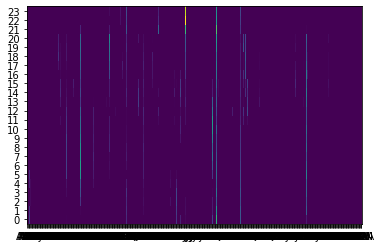

In [139]:
plt.pcolor(pesos_markowitz)
plt.yticks(np.arange(0.5, len(pesos_markowitz.index), 1), pesos_markowitz.index)
plt.xticks(np.arange(0.5, len(pesos_markowitz.columns), 1), pesos_markowitz.columns)
plt.show()

<AxesSubplot:ylabel='portafolio'>

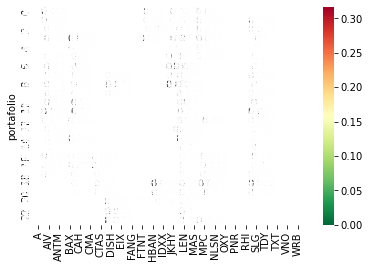

In [146]:
sns.heatmap(pesos_markowitz, cmap='RdYlGn_r', linewidths=0.5, annot=True)

In [163]:
def media_vol_portafolio(retornos, pesos, rf=0.02):
    r = annualize_rets(retornos, 253)
    retor = portfolio_return(pesos, r)
    cova = retornos.cov()
    vola = portfolio_vol(pesos, cova)
    vola = vola*np.sqrt(253)
    sharpe = (retor - rf)/vola
    return {"retorno_anual":retor, "desviacion_estandar_anual":vola, "sharpe_ratio":sharpe}

In [153]:
prueba1 = carga_datos('./Data/test/pereval-20150101-20150331.gzip')

In [154]:
prueba1.shape

(61, 465)

In [164]:
media_vol_portafolio(prueba1, pesos_markowitz.loc[0])

{'retorno_anual': 0.5859873476983248,
 'desviacion_estandar_anual': 0.16669310316926236,
 'sharpe_ratio': 3.3953855134823057}

In [167]:
## calculo para todos los portafolios de prueba

archivosT = []
path_trainT = "./Data/test/"
for root, dirs, files in os.walk("./Data/test/"):
    for filename in files:
        if 'gzip' in filename:
            temp = path_trainT + filename
            archivosT.append(temp)

archivosT

['./Data/test/pereval-20150101-20150331.gzip',
 './Data/test/pereval-20150401-20150630.gzip',
 './Data/test/pereval-20150701-20150930.gzip',
 './Data/test/pereval-20151001-20151231.gzip',
 './Data/test/pereval-20160101-20160331.gzip',
 './Data/test/pereval-20160401-20160630.gzip',
 './Data/test/pereval-20160701-20160930.gzip',
 './Data/test/pereval-20161001-20161231.gzip',
 './Data/test/pereval-20170101-20170331.gzip',
 './Data/test/pereval-20170401-20170630.gzip',
 './Data/test/pereval-20170701-20170930.gzip',
 './Data/test/pereval-20171001-20171231.gzip',
 './Data/test/pereval-20180101-20180331.gzip',
 './Data/test/pereval-20180401-20180630.gzip',
 './Data/test/pereval-20180701-20180930.gzip',
 './Data/test/pereval-20181001-20181231.gzip',
 './Data/test/pereval-20190101-20190331.gzip',
 './Data/test/pereval-20190401-20190630.gzip',
 './Data/test/pereval-20190701-20190930.gzip',
 './Data/test/pereval-20191001-20191231.gzip',
 './Data/test/pereval-20200101-20200331.gzip',
 './Data/test

In [181]:
resultadosT = []
for i in range(len(archivos)-1):
    data = carga_datos(archivosT[i])
    print(archivosT[i].split('/')[3].split('-')[1])
    salida = media_vol_portafolio(data, pesos_markowitz.loc[i])
    salida['trimeste_inicia'] = archivosT[i].split('/')[3].split('-')[1]
    resultadosT.append(salida)

20150101
20150401
20150701
20151001
20160101
20160401
20160701
20161001
20170101
20170401
20170701
20171001
20180101
20180401
20180701
20181001
20190101
20190401
20190701
20191001
20200101
20200401
20200701


In [184]:
resultadosT = pd.DataFrame(resultadosT)
resultadosT = resultadosT.set_index('trimeste_inicia')

In [185]:
resultadosT

,retorno_anual,desviacion_estandar_anual,sharpe_ratio
trimeste_inicia,,,
20150101,0.585987,0.166693,3.395386
20150401,-0.021648,0.128258,-0.324720
20150701,0.027298,0.189605,0.038491
20151001,0.291799,0.140368,1.936336
20160101,0.085205,0.196617,0.331636
20160401,0.254669,0.116788,2.009362
20160701,0.219114,0.105868,1.880782
20161001,0.362199,0.094618,3.616641
20170101,0.487498,0.090051,5.191486


<AxesSubplot:xlabel='trimeste_inicia'>

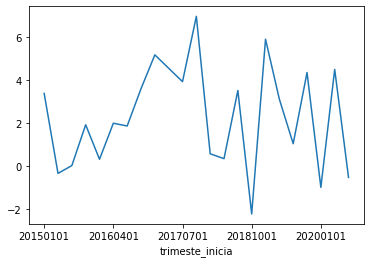

In [187]:
resultadosT['sharpe_ratio'].plot()